### Setup

In [2]:
%run utils/utils_data_cleaning.py

import matplotlib.pyplot as plt

### Load a subset of the dataset

In [88]:
df = load_taxi_data_chunk(chunk=50000)
handle_missing_data(df)
df.head()

Data loaded with 50000 entries and 10 columns
Size reduction from 50000 to 48804 (1196 samples dropped for missing data)


,pu_t,do_t,trip_dist,pu_lon,pu_lat,do_lon,do_lat,duration,vec_dist,trip_ratio
0,2016-02-16 19:56:06,2016-02-16 20:10:46,8.53,-73.995750,40.764488,-73.926292,40.867458,880,7.983998,1.068387
1,2016-02-11 10:23:41,2016-02-11 10:45:04,1.95,-73.994110,40.751068,-73.993401,40.736019,1283,1.039087,1.876648
2,2016-02-21 14:21:57,2016-02-21 14:30:07,0.50,-73.973160,40.752728,-73.982178,40.756962,490,0.556130,0.899070
3,2016-02-11 22:51:59,2016-02-11 22:57:41,1.30,-73.991280,40.744808,-73.985909,40.731178,342,0.981839,1.324045
4,2016-02-13 18:32:08,2016-02-13 18:43:51,1.50,-73.992897,40.741280,-73.975967,40.748734,703,1.026608,1.461123


### Target histogram (duration)

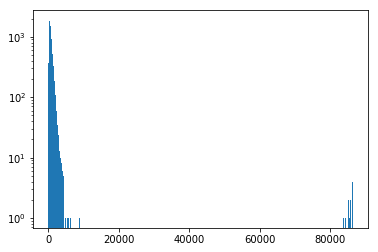

In [89]:
plt.figure()
plt.hist(df.duration, bins='auto', log=True)
plt.show()

Consindering the durations above 80k seconds (22 hours) as noise, let's zoom in a bit:

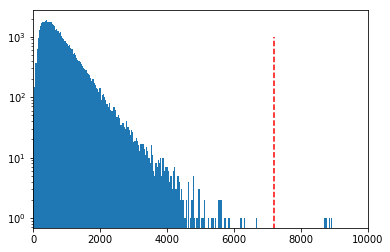

In [90]:
plt.figure()
plt.hist(df.duration, bins='auto', log=True)
plt.xlim(0,10000)
plt.plot((7200, 7200),(0,1e3), '--', c='r')
plt.show()

Seems reasonable to filter out any trips taking longer than 2 hours. 

In [91]:
print("{0:.2f}% of the trips last less than 2 hours".format(100*(df.duration < 7200).sum()/df.shape[0]))

99.83% of the trips last less than 2 hours


### Remove samples with too long duration (considered as outliers) 

In [92]:
print('# of duration outliers =', df[(df.duration > 7200)].shape[0])
handle_duration_outliers(df, 7200)

# of duration outliers = 83
Size reduction from 48804 to 48721 (83 samples dropped for having longer duration than 7200 seconds)


### Replot target histogram (duration) 

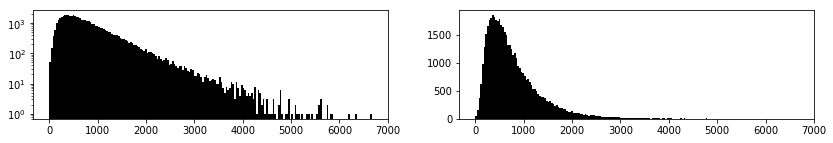

In [149]:
plt.figure(figsize=(14,2))
plt.subplot(1,2,1)
plt.hist(df.duration, bins='auto', log=True, color='k')
plt.subplot(1,2,2)
plt.hist(df.duration, bins='auto', log=False, color='k')
plt.show()

### Fit some distributions

- Normalize first:

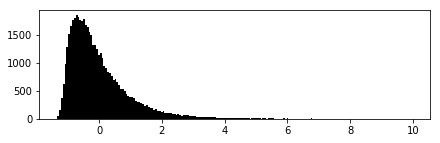

In [155]:
normalized_duration = (df.duration - df.duration.mean())/df.duration.std()
plt.figure(figsize=(7,2))
_,x,_ = plt.hist(normalized_duration, bins='auto', color='k')

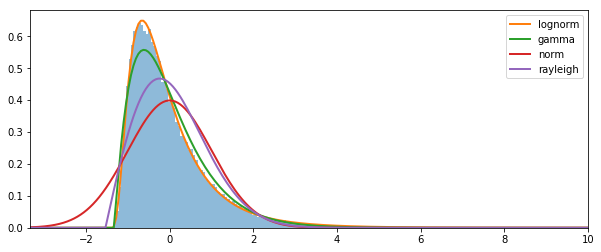

In [164]:
import numpy as np
from scipy import stats

plt.figure(figsize=(10,4))

plt.hist(normalized_duration, bins='auto', alpha=0.5, density=True)

dist_names = ['lognorm', 'gamma', 'norm', 'rayleigh']
parameters = []

left_x = np.linspace(x.min() - 2, x.min(), 1000)
x_axis = np.concatenate((left_x, x))

for dist_name in dist_names:
    
    dist = getattr(stats, dist_name)
    param = dist.fit(normalized_duration)
    parameters.append(param)
    
    shape = param[:-2]
    loc = param[-2]
    scale = param[-1]

    pdf_fitted = dist.pdf(x_axis, *param[:-2], loc=param[-2], scale=param[-1])
    plt.plot(x_axis, pdf_fitted, label=dist_name, linewidth=2)
    plt.xlim((x_axis.min(),10))
    plt.legend(loc='upper right')
plt.show()

### Pick-up / drop-off time histograms

In [8]:
# Measured in hours of a day
df['pu_hour'] = df.pu_t.apply(lambda s: s.hour)
df['do_hour'] = df.do_t.apply(lambda s: s.hour)

# Measured in seconds of a day
df['pu_second'] = df.pu_t.apply(lambda x : x.second + 60 * x.minute + 3600 * x.hour)
df['do_second'] = df.do_t.apply(lambda x : x.second + 60 * x.minute + 3600 * x.hour)

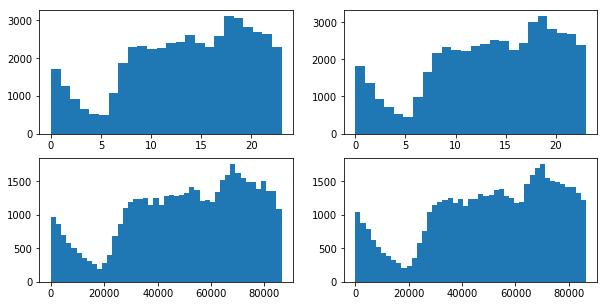

In [9]:
time_data = [df.pu_hour, df.do_hour, df.pu_second, df.do_second]

fig = plt.figure(figsize=(10,5))

ax = [fig.add_subplot(2,2,i+1) for i in range(4)]

ax[0].hist(time_data[0], bins=24)
ax[1].hist(time_data[1], bins=24)
ax[2].hist(time_data[2], bins='auto')
ax[3].hist(time_data[3], bins='auto')

plt.show()  

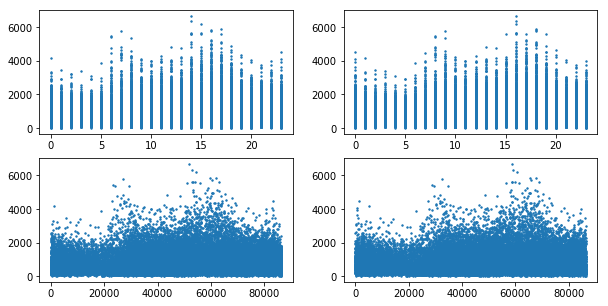

In [10]:
fig = plt.figure(figsize=(10,5))

ax = [fig.add_subplot(2,2,i+1) for i in range(4)]
ax[0].scatter(time_data[0], df.duration, s=2)
ax[1].scatter(time_data[1], df.duration, s=2)
ax[2].scatter(time_data[2], df.duration, s=2)
ax[3].scatter(time_data[3], df.duration, s=2)

plt.show()

--------
### Generating plots for project report

In [3]:
import pickle as pkl

In [4]:
df = pkl.load(open('../data/dataset_10M.pkl', 'rb'))
df = df.drop('index',axis=1)

#Randomly select 10% of the dataset to raise some statistics
df = df.sample(n = int(0.1 * len(df))).reset_index()
df = df.drop('index',axis=1)

df.head()

,pu_t,do_t,trip_dist,pu_lon,pu_lat,do_lon,do_lat,duration,vec_dist,trip_ratio
0,2016-02-18 12:50:37,2016-02-18 13:04:11,2.50,-73.955284,40.782970,-73.984756,40.771740,814,1.729315,1.445659
1,2016-01-16 17:16:39,2016-01-16 17:43:32,11.10,-73.981873,40.768642,-73.898918,40.895798,1613,9.792312,1.133542
2,2016-02-05 20:08:49,2016-02-05 20:18:55,1.80,-73.979057,40.781769,-73.954498,40.782463,606,1.289035,1.396394
3,2016-01-22 02:25:34,2016-01-22 02:28:55,0.81,-73.971748,40.761059,-73.970222,40.752560,201,0.591905,1.368464
4,2016-01-18 11:24:00,2016-01-18 11:33:42,1.50,-73.971558,40.757938,-73.990356,40.751385,582,1.085142,1.382308


In [5]:
print(len(df))

1000000


### 1) Output distribution

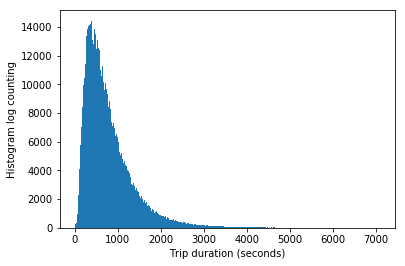

In [6]:
plt.figure()
plt.hist(df.duration, bins='auto', log=False)
plt.ylabel('Histogram log counting')
plt.xlabel('Trip duration (seconds)')
plt.show()

Computing distributions...
Distribution lognorm
Distribution gamma
Distribution norm
Distribution rayleigh


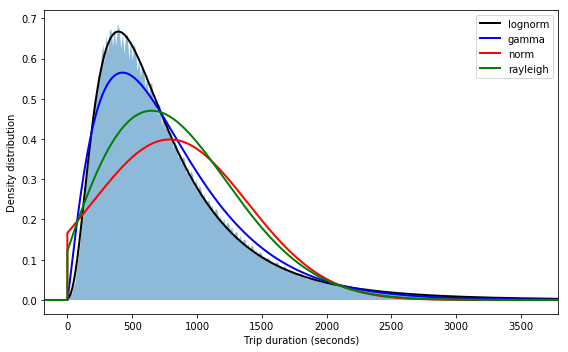

Done.


In [7]:
import numpy as np
from scipy import stats

normalize = False

normalized_duration = (df.duration - df.duration.mean())/df.duration.std()

y,x,_ = plt.hist(df.duration, bins='auto', alpha=0.5, density=True)
y_normalized,x_normalized,_ = plt.hist(normalized_duration, bins='auto', alpha=0.5, density=True)
plt.close()

dist_names = ['lognorm', 'gamma', 'norm', 'rayleigh']

colors = ['black','blue','red','green']

parameters = []

#Pick
if not normalize:
    x_axis = x; y_axis = np.sum(y_normalized)/np.sum(y) * y; left_wing = 0.3 * df.duration.std()
else:
    x_axis = x_normalized; y_axis = y_normalized; left_wing = 0.3

left_x = np.linspace(x_axis.min() - left_wing, x_axis.min(), 1000)

x_axis = np.concatenate((left_x, x_axis))
y_axis = np.concatenate((np.zeros(len(left_x)+1), y_axis))

# Plot distribution
plt.figure(figsize=(8,5))
plt.fill(x_axis, y_axis, alpha = 0.5)

print('Computing distributions...')

#distributions = []

for index, dist_name in enumerate(dist_names):
    
    print('Distribution', dist_name)
    
    dist = getattr(stats, dist_name)
    param = dist.fit(normalized_duration)
    parameters.append(param)
    
    shape = param[:-2]
    loc = param[-2]
    scale = param[-1]
    
    pdf_fitted = dist.pdf(x_normalized, *param[:-2], loc=param[-2], scale=param[-1])
    pdf_fitted = np.concatenate((np.zeros_like(left_x), pdf_fitted))

    plt.plot(x_axis, pdf_fitted, label=dist_name, linewidth=2, c=colors[index])
    
plt.xlim((x_axis.min(), 5 * df.duration.std() + df.duration.mean()))
plt.xlabel('Trip duration (seconds)')
if normalize:
    plt.xlim((x_axis.min(),5))
    plt.xlabel('Trip duration (normalized by standard deviation)')

plt.ylabel('Density distribution')
plt.legend(loc='upper right')

plt.tight_layout()

if normalize:
    plt.savefig('../figures/trip_duration_distribution_norm.png', dpi=500, bbox='tight');    
else:
    plt.savefig('../figures/trip_duration_distribution.png', dpi=500, bbox='tight');    
plt.show()

print('Done.')

In [14]:
100*len(df[df.duration < 2000])/len(df)

95.5263

### 2) Hour of trip distribution

In [266]:
df['trip_hour'] = df.apply(lambda s: pd.Timestamp(np.mean((s.pu_t.value, s.do_t.value))).hour, axis = 1)

In [286]:
# Monday == 0 … Sunday == 6
df['week_day'] = df.apply(lambda s: pd.Timestamp(np.mean((s.pu_t.value, s.do_t.value))).weekday(), axis = 1)

In [288]:
df.head()

,pu_t,do_t,trip_dist,pu_lon,pu_lat,do_lon,do_lat,duration,vec_dist,trip_ratio,trip_hour,week_day
0,2016-01-25 20:46:17,2016-01-25 21:02:59,2.40,-74.002968,40.725090,-73.993385,40.752556,1002,1.960810,1.223984,20,0
1,2016-01-13 03:12:34,2016-01-13 03:31:42,6.50,-73.986763,40.725616,-73.905556,40.739471,1148,4.368460,1.487938,3,2
2,2016-02-16 08:37:22,2016-02-16 08:42:43,1.46,-73.964844,40.764149,-73.950691,40.780964,321,1.377490,1.059899,8,1
3,2016-01-31 03:57:15,2016-01-31 04:10:01,4.45,-73.988609,40.731289,-73.946388,40.777309,766,3.871992,1.149279,4,6
4,2016-02-10 20:27:11,2016-02-10 20:30:02,0.47,-73.977348,40.758423,-73.977852,40.753708,171,0.326417,1.439877,20,2


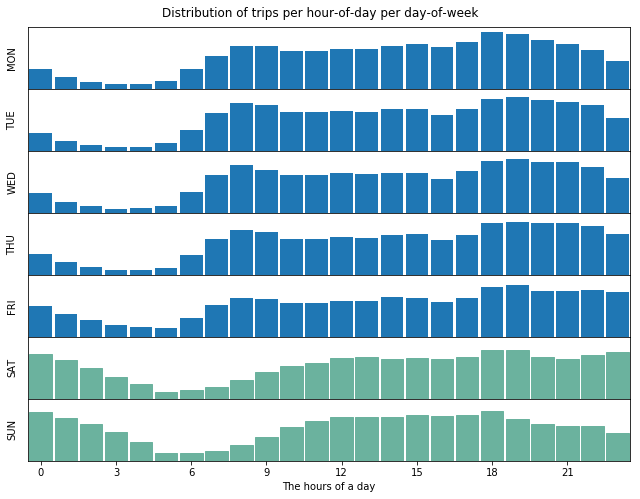

In [592]:
day = ['MON','TUE','WED','THU','FRI','SAT','SUN']

bins = []
for d in range(7):
    y,x,_ = ax1.hist(df[df.week_day == d].trip_hour, bins=24, density=True)
    bins.append(y)
    
fig = plt.figure(figsize=(9,7))

x = np.arange(24)
max_y = 0.08
plt.ylim((0,max_y))

ax0 = None
for d in range(0,7):
    ax1 = plt.subplot(7,1,d+1, sharex = ax0)
    bars = ax1.bar(x, bins[d], width=.9)
    plt.ylim((0,max_y))
    ax1.yaxis.set_visible(True)
    ax1.set_yticklabels([])
    ax1.set_ylabel(day[d])
    ax1.tick_params(axis='y', left=False)
    if d == 0:
        ax0 = ax1
    if d > 4:
        [bar.set_color('#6bb29e') for bar in bars]

fig.suptitle('Distribution of trips per hour-of-day per day-of-week') # or plt.suptitle('Main title')

fig.tight_layout()
fig.subplots_adjust(top=0.94, bottom = 0.08)

ax1.xaxis.set_ticks(np.arange(0,24,3))
plt.xlabel('The hours of a day')
plt.xlim((-.5,23.5))
plt.subplots_adjust(hspace=.0)

plt.savefig('../figures/trip_per_day_distribution.png', dpi=500);    
plt.show()